# Model 4: Biased transmission (indirect bias)

original: https://bookdown.org/amesoudi/ABMtutorial_bookdown/model4.html

### Note

- Certain demonstrators are more likely to be copied than other demonstrators.
- For this reason, indirect bias is sometimes called ‘demonstrator-based’ or ‘context’ bias.
- Learners might preferentially copy
    - demonstrators who have high success or payoffs (which may or may not derive from their cultural traits),
    - demonstrators who are old (and perhaps have accrued valuable knowledge, or at least good enough to keep them alive to old age),
    - demonstrators who are the same gender as the learner (if cultural traits are gender-specific), or
    - demonstrators who possess high social status or prestige.

## Model 4a: Payoff bias

In [1]:
using DataFrames
using Statistics
using StatsBase
using Plots
gr();

In [2]:
@enum Trait A B

# modeified based on model 3
function make_agents_df(N::Int64, p_0::Float64, s::Float64)::DataFrame
    traits = [rand() < p_0 ? A : B for _ in 1:N]
    payoffs = [t == A ? 1.0 + s : 1.0 for t in traits]
    return DataFrame(trait = traits, payoff = payoffs)
end

# same as model 3
function make_outputs_df(r_max::Int64, t_max::Int64)::DataFrame
    # r: trial number
    # t: generation number
    # p: proportion of individuals who possess trait A
    return DataFrame(
        r = fill(0, r_max * t_max),
        t = fill(0, r_max * t_max),
        p = fill(-1.0, r_max * t_max)
    )
end

# same as model 3
function calc_p(_agents_df::DataFrame)::Float64
    return nrow(_agents_df[_agents_df.trait.==A, :]) / nrow(_agents_df)
end

# same as model 3
function plot_outputs_df(outputs_df::DataFrame, title::String)::Plots.Plot
    p = plot(
        outputs_df[outputs_df.r.== 1, :].p,
        ylims = (-0.01, 1.01),
        title = title,
        xlabel = "generation",
        ylabel = "p, proportion of agents with trait A",
        legend = false
    )
    for r = 2:maximum(outputs_df.r)
        plot!(outputs_df[outputs_df.r.== r, :].p)
    end
    
    mean_df = combine(groupby(outputs_df, :t), :p => mean)
    plot!(mean_df.p_mean, lw = 4, lc = :black)

    return p
end

# modeified based on model 3
# N: population
# r_max: number of independent runs
# t_max: max of generations (t)
function biased_transmission(N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, s::Float64)::DataFrame
    outputs_df = make_outputs_df(r_max, t_max)

    for r = 1:r_max
        agents_df = make_agents_df(N, p_0, s)

        for t = 1:t_max
            if t > 1
                agents_df.trait = sample(agents_df.trait, ProbabilityWeights(agents_df.payoff), N)
                agents_df.payoff = [t == A ? 1.0 + s : 1.0 for t in agents_df.trait]
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            outputs_df.r[row_num] = r
            outputs_df.t[row_num] = t
            outputs_df.p[row_num] = calc_p(agents_df)
        end
    end
    
    return outputs_df
end

# same as model 3
function run(; N::Int64 = 100, r_max::Int64 = 10, t_max::Int64 = 200, p_0::Float64 = 0.5, s::Float64 = 0.1)
    outputs_df = biased_transmission(N, r_max, t_max, p_0, s)
    plot_outputs_df(outputs_df, "N = $N, p_0 = $p_0, s = $s")
end;

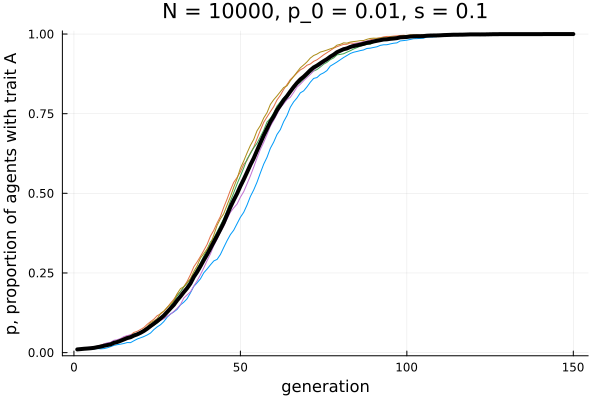

In [3]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, s = 0.1)

### Note

- Given that in Model 4a an agent’s payoff is entirely determined by their cultural trait.
- Under these assumptions, preferentially copying high payoff agents is functionally equivalent to preferentially copying high payoff traits (Model 3).

## Model 4b: Cultural hitch-hiking

### Note

- individuals possess two cultural traits, one functional (A / B) and the other neutral (X / Y).
- $p$: probability of $A$ ($1 - p$: $B$).
- $q$: probability of $X$ ($1 - q$: $Y$).
- We will model a situation where the two traits may be initially linked.We will model a situation where the two traits may be initially linked.
- We define a parameter $L$ that specifies the probability in the initial generation that, if an individual has an $A$ for trait 1, they also have an $X$ for trait 2.


In [4]:
@enum Trait A B X Y

function trait2(trait1::Trait, q_0::Float64, L::Float64)::Trait
    return if L > rand()
        trait1 == A ? X : Y
    else
        q_0 > rand() ? X : Y
    end
end

function make_agents_df(N::Int64, p_0::Float64, q_0::Float64, L::Float64, s::Float64)::DataFrame
    traits1 = [rand() < p_0 ? A : B for _ in 1:N]
    payoffs = [t == A ? 1.0 + s : 1.0 for t in traits1]
    traits2 = [trait2(t1, q_0, L) for t1 in traits1]
    return DataFrame(trait1 = traits1, trait2 = traits2, payoff = payoffs)
end

function make_outputs_df(r_max::Int64, t_max::Int64)::DataFrame
    # r: trial number
    # t: generation number
    # p: proportion of individuals who possess trait A
    return DataFrame(
        r = fill(0, r_max * t_max),
        t = fill(0, r_max * t_max),
        p = fill(-1.0, r_max * t_max),
        q = fill(-1.0, r_max * t_max)
    )
end

function calc_p(_agents_df::DataFrame)::Float64
    return nrow(_agents_df[_agents_df.trait1.==A, :]) / nrow(_agents_df)
end

function calc_q(_agents_df::DataFrame)::Float64
    return nrow(_agents_df[_agents_df.trait2.==X, :]) / nrow(_agents_df)
end

function plot_outputs_df(outputs_df::DataFrame, title::String)::Plots.Plot
    p = plot(
        outputs_df[outputs_df.r.== 1, :].p,
        lc = :orange,
        ylims = (-0.01, 1.01),
        title = title,
        xlabel = "generation",
        ylabel = "p and q, proportion of agents with trait A and X",
        legend = false
    )
    for r = 2:maximum(outputs_df.r)
        plot!(outputs_df[outputs_df.r.== r, :].p, lc = :orange)
    end
    
    for r = 1:maximum(outputs_df.r)
        plot!(outputs_df[outputs_df.r.== r, :].q, lc = :royalblue)
    end
    
    mean_df = combine(groupby(outputs_df, :t), [:p => mean, :q => mean])
    plot!(mean_df.p_mean, lw = 4, lc = :orange)
    plot!(mean_df.q_mean, lw = 4, lc = :royalblue)

    return p
end

function biased_transmission(N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, q_0::Float64, L::Float64, s::Float64)::DataFrame
    outputs_df = make_outputs_df(r_max, t_max)

    for r = 1:r_max
        agents_df = make_agents_df(N, p_0, q_0, L, s)

        for t = 1:t_max
            if t > 1
                demonstrators = sample(1:N, ProbabilityWeights(agents_df.payoff), N)
                agents_df.trait1 = [agents_df.trait1[d] for d in demonstrators]
                agents_df.trait2 = [agents_df.trait2[d] for d in demonstrators]
                agents_df.payoff = [t == A ? 1.0 + s : 1.0 for t in agents_df.trait1]
            end

            # get p and put it into the output slot for this generation t
            row_num = t + (r - 1) * t_max
            outputs_df.r[row_num] = r
            outputs_df.t[row_num] = t
            outputs_df.p[row_num] = calc_p(agents_df)
            outputs_df.q[row_num] = calc_q(agents_df)
        end
    end
    
    return outputs_df
end

# same as model 3
function run(; N::Int64, r_max::Int64, t_max::Int64, p_0::Float64, q_0::Float64, L::Float64, s::Float64)
    outputs_df = biased_transmission(N, r_max, t_max, p_0, q_0, L, s)
    plot_outputs_df(outputs_df, "N = $N, p_0 = $p_0, q_0 = $q_0, L = $L, s = $s")
end;

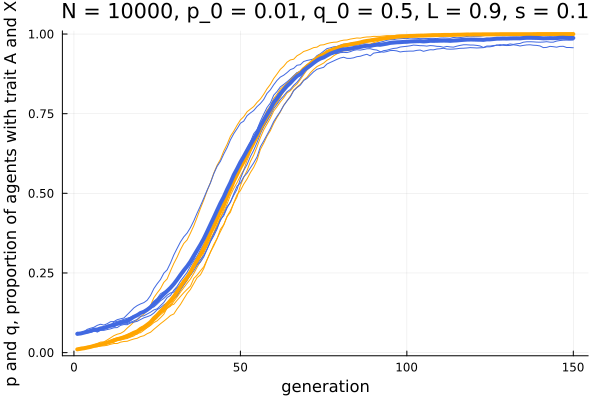

In [5]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, q_0 = 0.5, L = 0.9, s = 0.1)

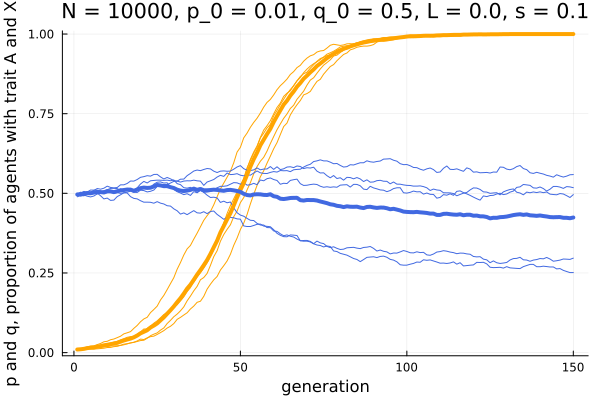

In [6]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.01, q_0 = 0.5, L = 0.0, s = 0.1)

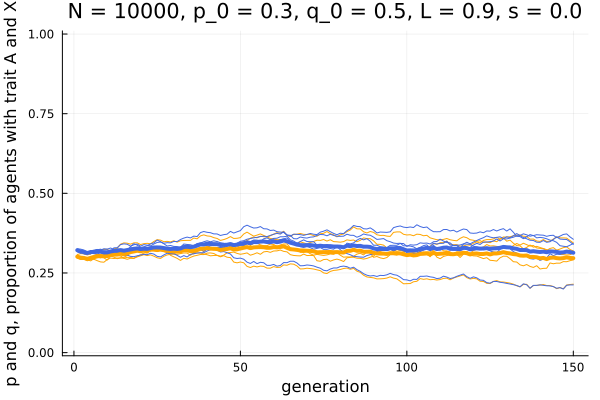

In [7]:
run(N = 10^4, r_max = 5, t_max = 150, p_0 = 0.3, q_0 = 0.5, L = 0.9, s = 0.0)